# Résultats du challenge:

https://www.dropbox.com/s/uomf1gwrpeirhqi/challenge_debrief.pdf?dl=0

# Prédiction du genre d'une personne à partir de sa photo

L'objectif est de prédire le genre d'une personne (homme ou femme) à partir de caractéristiques extraites d'une photo.
Les données sont fournies par la société Morpho: http://www.morpho.com/fr
Le fichier que doit fournir chacun est un fichier au format .txt de 4991 lignes:b 1, 0, -1 ...
où chaque ligne contient la prédiction. Contrairement à un problème de classification binaire où y=1 ou y=-1, vous avez la possibilité de prédire 0, ce qui signifie que vous ne savez pas. Il y a 4991 images dans l'ensemble de validation.

### Critère de performance 

Vous pouvez donc répondre pour chaque image : homme (y=1), femme (y=-1) ou je-ne-sais-pas (y=0).
Se tromper coûte 10 points et ne pas savoir coûte 1 point. Mathématiquement, le score est calculé de la façon suivante:
$score = \frac1{N} \sum_{i=1}^N \Bigl(\mathbb{1}(\hat{y}_i = 0) + 10 \times \mathbb{1}(y_i \hat{y}_i = -1)   \Bigr) $ 
où $\mathbb{1}(\cdot)$ est la fonction indicatrice; $\mathbb{1}(x) = 1$ si $x$ est vrai, et $\mathbb{1}(x) = 0$, sinon.
Plus ce nombre est petit mieux c'est.
###  Données d'apprentissage: 

data/training_templates.csv

data/training_labels.txt

###  Données de validation:

data/testing_templates.csv

Nous allons commencer par donner un plan décrivant les étapes que nous avons suivies pour produire notre modèle final. Il faut noter qu'à chaque étape, nous allons présenter parfois des idées ou pistes que nous avons suivies et qui n'ont pas été interessantes par la suite.

## Plan de travail:

**Etape 1:** visualisation des données (nuages de points, box plot, ...)

**Etape 2:** reduction du volume des données par sélection des données pertinentes

**Etape 3:** Exécution d'un ensemble de modèle avec les paramètres de base sur le jeu de données retenu

**Etape 4:** Exploration des modèles retenus en se basant des résultats de la phase 3.

**Etape 5:** Combinaison des modèles

    5.1 vote sur les meilleurs modèles
    
    5.2 Implémentaion d'une procédure de reentrainement sur les predictions des meilleurs modèles retenus

### Paquets importants

In [4]:
#import useful pakege
import pandas as pd
import numpy as np


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import NuSVC
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, \
                             GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import model_selection, metrics
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, precision_score, recall_score, f1_score

from sklearn.model_selection  import GridSearchCV
from sklearn.model_selection  import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer

from sklearn.model_selection import KFold, StratifiedKFold


from sklearn.lda import LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import scale
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.learning_curve import learning_curve
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn.externals import joblib

from sklearn import preprocessing

import matplotlib
#matplotlib.style.use('ggplot')
import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import warnings
warnings.filterwarnings('ignore')

C:\Users\fokou\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\fokou\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


### **Etape 0:** Lecture des données

Nous travaillererons avec des dataFrames pandas pour des raisons de simplicité. Nous allons créer pour cela un unique dataFrame contenant les données de train (features et classe [feat_0, Feat_1, ..., Feat_127, genre]) et un unique dataFrame pour les données de test ([feat_0, Feat_1, ..., Feat_127])


In [6]:
X_train_fname = 'data/training_templates_reduce.csv'
y_train_fname = 'data/training_labels_reduce.csv'
X_test_fname  = 'data/testing_templates.csv'

X_train = pd.read_csv(X_train_fname, sep=',', header=None)
X_test  = pd.read_csv(X_test_fname,  sep=',', header=None)
y_train = pd.read_csv(y_train_fname)

X_train.shape, X_test.shape, y_train.shape, np.mean(y_train), np.unique(y_train)

((30001, 128), (8496, 128), (29999, 1), 1    1.0
 dtype: float64, array([1], dtype=int64))

In [11]:
X_train.head(30000).to_csv('data/training_templates_reduce.csv', index=False)
pd.Series(y_train).head(30000).to_csv('data/training_labels_reduce.csv', index=False)

In [ ]:
predictors = ['feat_'+str(i) for i in range(X_train.shape[1])]
X_train.columns = predictors
X_test.columns = predictors

target = 'genre'
IDcol = 'ID'
# fix this parameter for evaluation
random_state = 42

# le = preprocessing.LabelEncoder()
# le.fit(y_train)

X_train[target] = y_train

X_train.index.name = IDcol

### **Etape 1:** visualisation des données 

Nous allons commencer par faire une reduction de la dimension (dimension = 2) afin de visaliser un nuage de points pour chacune des classes (Hommes vs Femmes)

In [12]:
def plotting_point(X,y, label):
    """ cette fonction permet d'afficher un jeu de données sous forme de nuage de points. 
    La fonction projète les données en dimension 2 avec PCA et affiche le nuage de points
    - X: Matrice des données
    - y: vecteur des classes
    - label: label des classes
    """
    
    y_train = np.array(y)
    pca = PCA(n_components=2)
    pca.fit(np.array(X))
    X1 =pca.fit_transform(X)

    sample_weight = np.random.RandomState(42).rand(y_train.shape[0])

    plt.figure(figsize=(9, 6))
    y_unique = np.unique(y_train)
    colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X1[y_train == this_y]
        this_sw = sample_weight[y_train == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50, c=color, alpha=0.5,
                    label=label[this_y])
    plt.legend(loc="best")
    plt.title("Data")

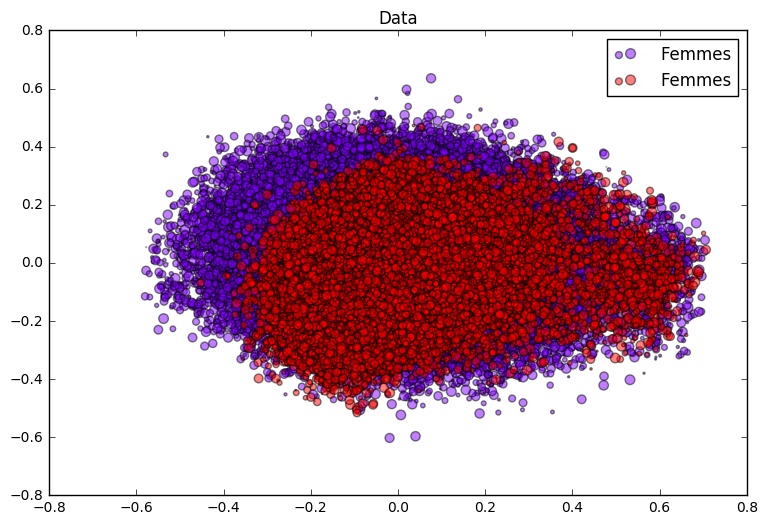

In [13]:
plotting_point(X_train[predictors],X_train[target], ["Hommes","Femmes"])

On remarque que les données sont assez mélangées entre les deux classes; et ne nous informent pas diectement beaucoup sur le type d'algorithme à utiliser. Ceci suppose qu'il faudra probablement essayer un ensemble d'algorithme.

Nous allons afficher des graphiques de distribution de données afin de voir si des tranformations sur celles ci pourraient etre necessaire

### Plots univariés

#### Histogramme & BoxPlot

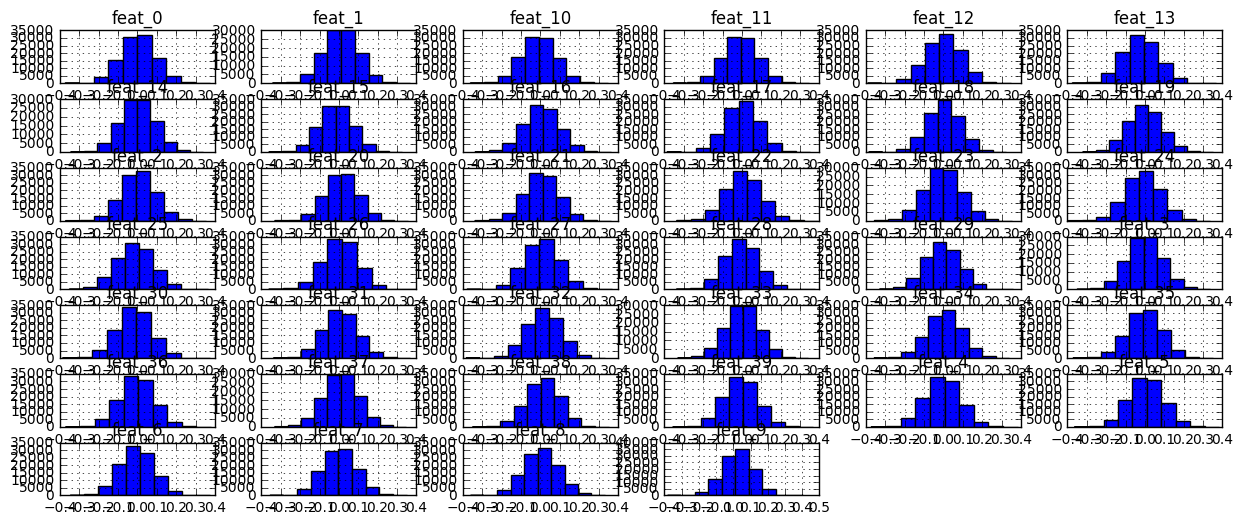

In [14]:
X_train.iloc[:,:40].hist() #.hist() .plot(kind='density')
plt.show()

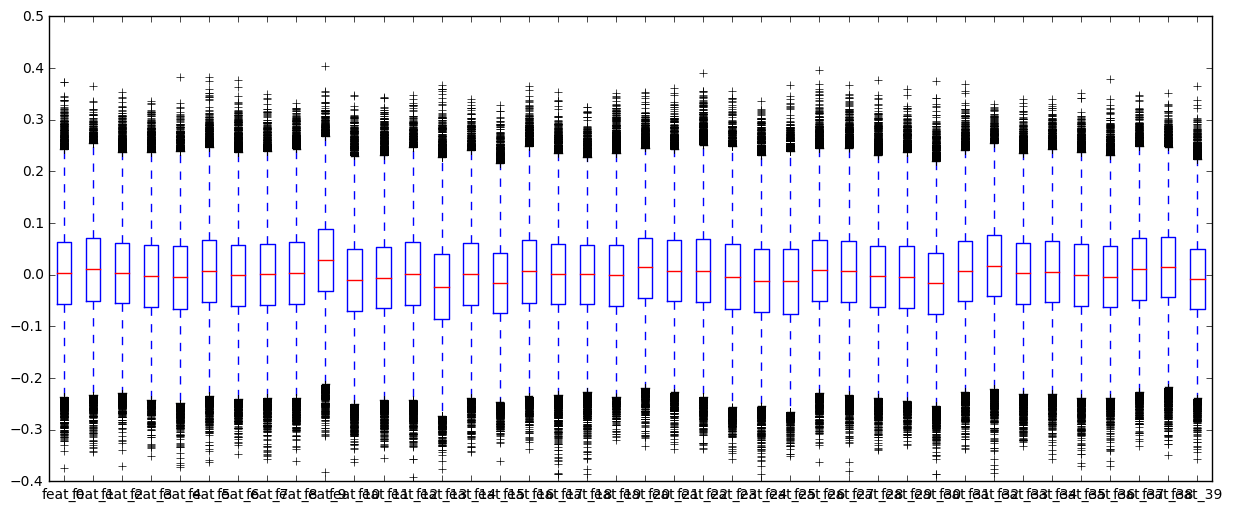

In [15]:
X_train.iloc[:,:40].plot(kind='box')
plt.show()

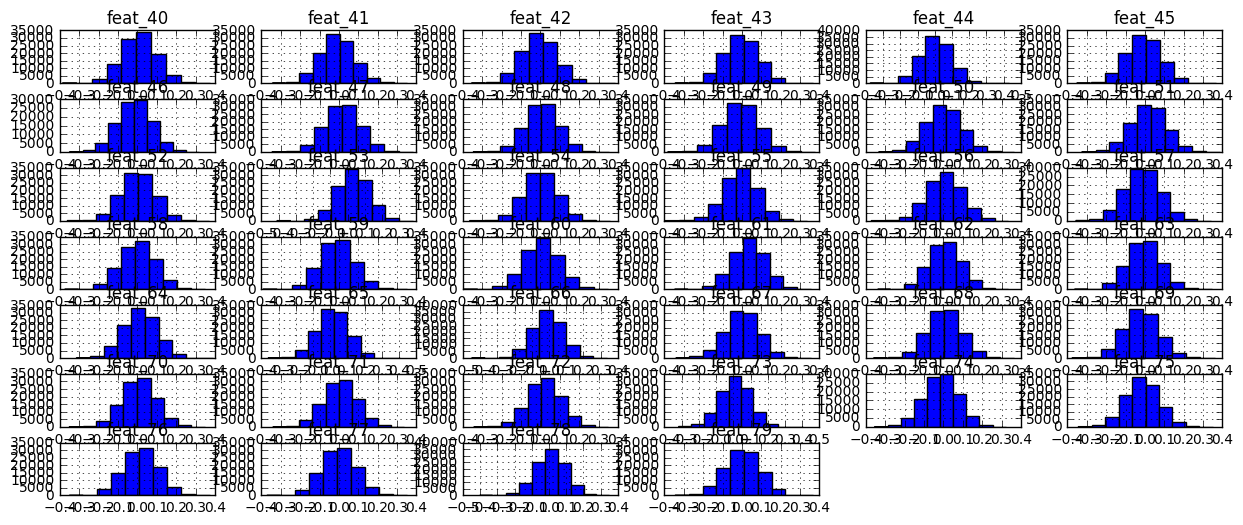

In [16]:
X_train.iloc[:,40:80].hist() #.hist() plot(kind='density')
plt.show()

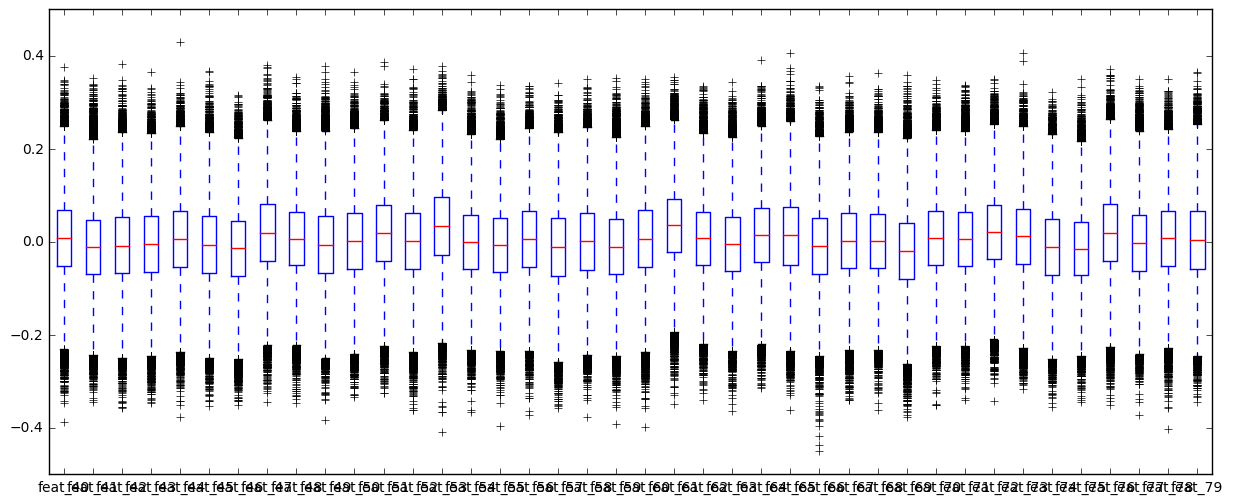

In [17]:
X_train.iloc[:,40:80].plot(kind='box')
plt.show()

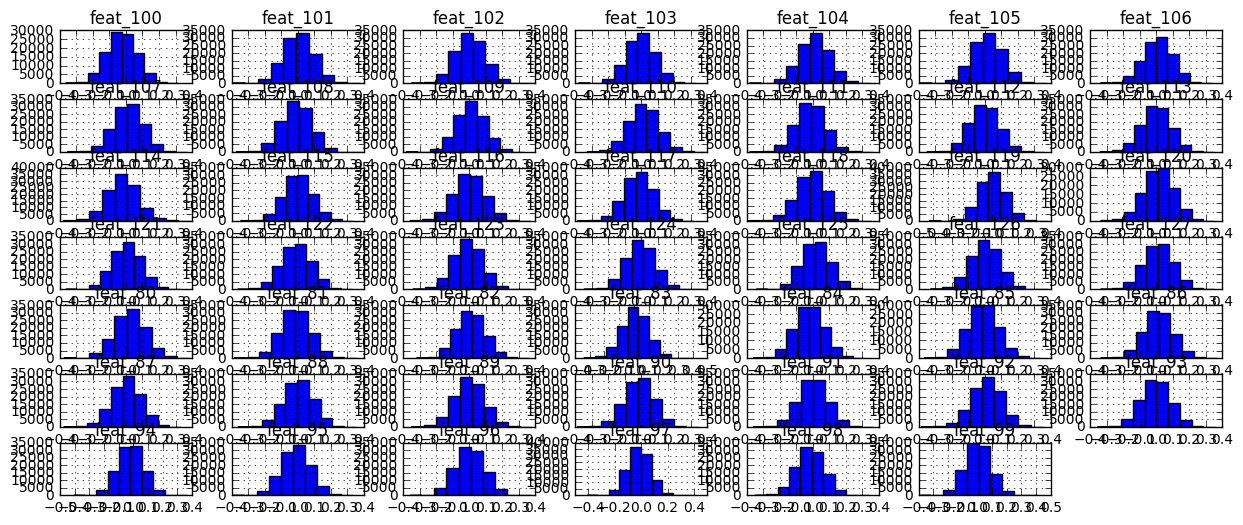

In [18]:
X_train.iloc[:,80:128].hist() #.hist() plot(kind='density')
plt.show()

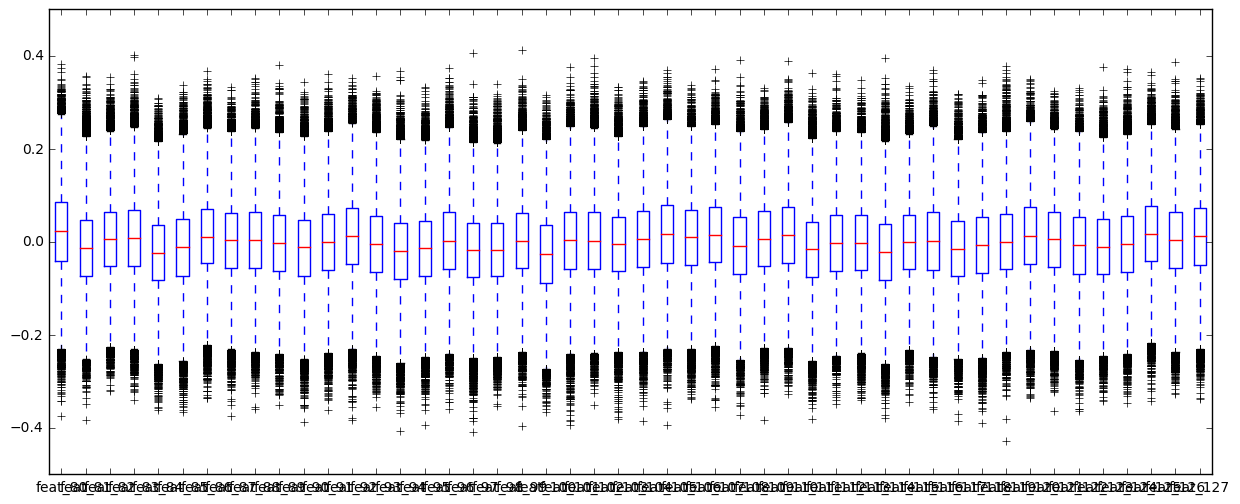

In [19]:
X_train.iloc[:,80:128].plot(kind='box')
plt.show()

On remarque que les features suivent des distrubutions gaussiennes; ceci suppose qu'aucune transformation appriori n'est necessaire. 

Les box plots nous permettent de constater que des données pourraient etre assez bruitées; nous devons donc filtrer les données d'une part pour reduire le bruit mais aussi pour pouvoir faire tourner nos programmes sur nos machines qui ne sont pas très puissantes

### Plots multivariés

#### Matrice de corrélation  & Scatterplot

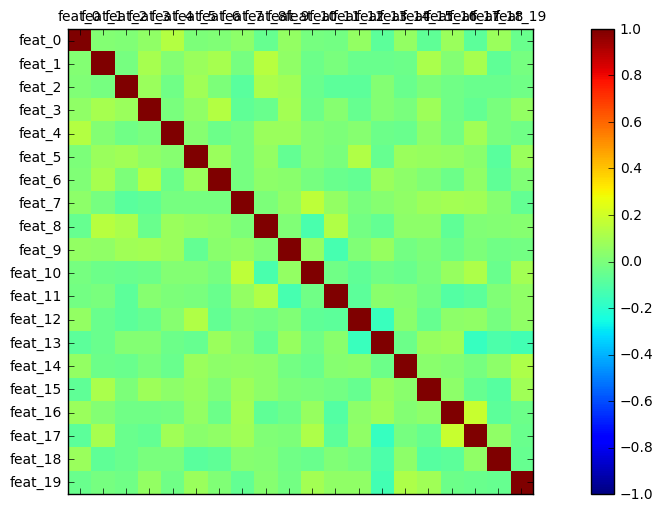

In [20]:
nbFeat = 20

correlations = X_train.iloc[:,:nbFeat].corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,nbFeat,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(predictors)
ax.set_yticklabels(predictors)
plt.show()

On remarque que les features sont tres peu corrélés entre eux

Ici nous remarquons que en considerant les features deux à deux le nuage de point n'est toujours pas dissipé.

### **Etape 2:** reduction du volume des données par sélection des données pertinentes

Cette étape est très importante car elle permet d'une part de reduire le bruit mais aussi de definir un volume de données que l'on puisse faire tourner sur nos machines.

Nous avons employé différentes methodes de reduction du bruit afin d'améliorer notre score au tableau. Nous allons juste donner les idées pour les méthodes non retenues et le code de la méthode retenue

Parmi les méthodes que nous avons testées, il y'a:

- Supprimer les données qui possèdent des valeurs extèmes sur une feature quelconque. Etant donnée une donnée "data" et une feature "x", on supprime la donnée si elle verifie l'une des condition suivante:

   - data < condition x.quantile(q=.25) - (1.5*x.quantile(q=.75)-x.quantile(q=.25))
   
   - data > x.quantile(q=.75) + (1.5*x.quantile(q=.75)-x.quantile(q=.25))

-  Utilisation de la classe svm.OneClassSVM (http://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py). Il s'agit en fait d'un algorithme non supervisé qui apprend une fonction de décision sur des données de train et ensuite utilise cette frontière pour classer les nouvelles données comme similaires ou différentes de l'ensemble de données de train. Ici nos données de train sont les données de test fournis pour le challenge et les donnnées de test sont les  données de train fournis pour le challenge car le but est garder les données de train qui correspondent à la distribution des données de test.

Finalemnt toutes ces méthodes sophistiquées n'ont pas été productives pour le resultat final. Finalment nous avons opté pour une méthode simple qui consiste à garder les données de train corrélées aux données de test

** Reduction des données (bruit) en se basant sur cette dernière approche**

In [22]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=20, algorithm='brute', n_jobs=-1).fit(X_train[predictors].values)
distances, indices = nbrs.kneighbors(X_test[predictors].values)
np.savetxt('indices_to_train.txt', indices, delimiter=',')

In [23]:
max_neighbors = 1
ind_to_train = list(set(indices[:,:max_neighbors].flatten()))
print(X_train.iloc[ind_to_train].shape[0] == len(ind_to_train))
X_train_to_train = X_train.iloc[ind_to_train].copy()
(X_train_to_train[target] == 1).sum(),(X_train_to_train[target] == 0).sum()

True


(4726, 0)

In [24]:
X_train_to_train.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_119,feat_120,feat_121,feat_122,feat_123,feat_124,feat_125,feat_126,feat_127,genre
ID,,,,,,,,,,,,,,,,,,,,,
3,0.046740,-0.078993,0.070488,-0.105546,0.010218,0.049286,0.002658,0.098187,-0.142794,0.032278,...,0.039743,0.143476,0.184744,0.033412,-0.046099,0.068120,-0.040596,0.003668,-0.129293,1
7,0.078417,-0.083352,-0.009408,-0.088542,0.070803,-0.030806,0.051553,-0.031342,-0.056621,0.096728,...,0.070042,0.072558,-0.003728,0.075184,-0.055902,-0.010347,-0.035231,0.074564,-0.023212,1
32776,0.144059,0.066710,-0.160182,-0.036942,-0.042801,0.127102,0.001391,0.077111,-0.089493,0.022853,...,0.065365,0.100612,0.134147,-0.037384,0.136040,-0.012139,0.028243,0.178931,0.010690,1
98319,0.086047,0.095491,0.050520,0.069771,0.175355,-0.078999,-0.006906,-0.133826,0.030552,0.008573,...,0.010862,0.037572,0.080408,0.000286,-0.021744,0.059998,-0.127297,0.003120,-0.068264,-1
98320,-0.182174,0.117533,0.047692,-0.109557,0.024422,-0.073742,-0.049320,0.087411,-0.040185,0.162107,...,-0.017147,-0.011842,-0.057748,-0.221091,-0.153309,0.020815,-0.065699,0.066744,0.020549,-1


### **Etape 3:** Exécution d'un ensemble de modèle avec les paramètres de base sur le jeu de données retenu

Tenant compte de l'homogéneité dans les données, il est difficile pour nous d'avoir une intuition des algorithmes à utiliser. Nous allons initialement tester différents algorithmes avec leur paramètres de base et voir ce que nous pouvons tirer de cela

In [25]:
def evaluation_model(X, Y, models = [('LR', LogisticRegression()), ('SVM', SVC())], num_folds = 5, seed = 42):
    """ cette fonction permet de calculer les performances de différents algorithmes
    - X: Matrice des données
    - y: vecteur des classes
    - models: ensemble de modèle
    - num_folds: nombre de fold pour la cross-val
    - seed: racine pour la reproductivité des resultats
    """
    
    num_instances = len(X)
    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        #kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        #kfold = KFold(n=num_instances, n_folds=num_folds, random_state=seed)
        kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring, verbose = 0, n_jobs = -1)
        results.append(cv_results)
        names.append(name)
        msg = "%s: Precision mean %f Precison std (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names, rotation='vertical')
    plt.show()
    return results

In [26]:
names = ["LogisticRegression",
         "KNeighborsClassifier", 
         "QuadraticDiscriminantAnalysis", 
         "GaussianNB",
         "RidgeClassifierCV", 
         "AdaBoostClassifier", 
         "BaggingClassifier", 
         "GradientBoostingClassifier",
         "DecisionTreeClassifier", 
         "ExtraTreesClassifier",
         "RandomForestClassifier", 
         "XGBClassifier",
         "MLPClassifier", 
         "SVC",
         "NuSVC"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(n_jobs=-1),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(),
    RidgeClassifierCV(),
    AdaBoostClassifier(random_state=random_state),
    BaggingClassifier(n_jobs=-1, random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    RandomForestClassifier(n_jobs=-1, random_state=random_state),
    XGBClassifier(seed=random_state, nthread=-1),
    MLPClassifier(random_state=random_state),
    SVC(random_state=random_state),
    NuSVC(random_state=random_state)
    ]

LogisticRegression: Precision mean 0.930316 Precison std (0.007555)
KNeighborsClassifier: Precision mean 0.958819 Precison std (0.015133)
QuadraticDiscriminantAnalysis: Precision mean 0.955834 Precison std (0.020111)
GaussianNB: Precision mean 0.880476 Precison std (0.018877)
RidgeClassifierCV: Precision mean 0.942403 Precison std (0.007558)
AdaBoostClassifier: Precision mean 0.830202 Precison std (0.016045)
BaggingClassifier: Precision mean 0.841394 Precison std (0.006660)
GradientBoostingClassifier: Precision mean 0.901970 Precison std (0.006660)
DecisionTreeClassifier: Precision mean 0.755002 Precison std (0.008724)
ExtraTreesClassifier: Precision mean 0.817960 Precison std (0.012609)
RandomForestClassifier: Precision mean 0.829897 Precison std (0.013052)
XGBClassifier: Precision mean 0.904507 Precison std (0.006847)
MLPClassifier: Precision mean 0.970756 Precison std (0.014059)
SVC: Precision mean 0.739032 Precison std (0.004350)
NuSVC: Precision mean 0.898987 Precison std (0.00506

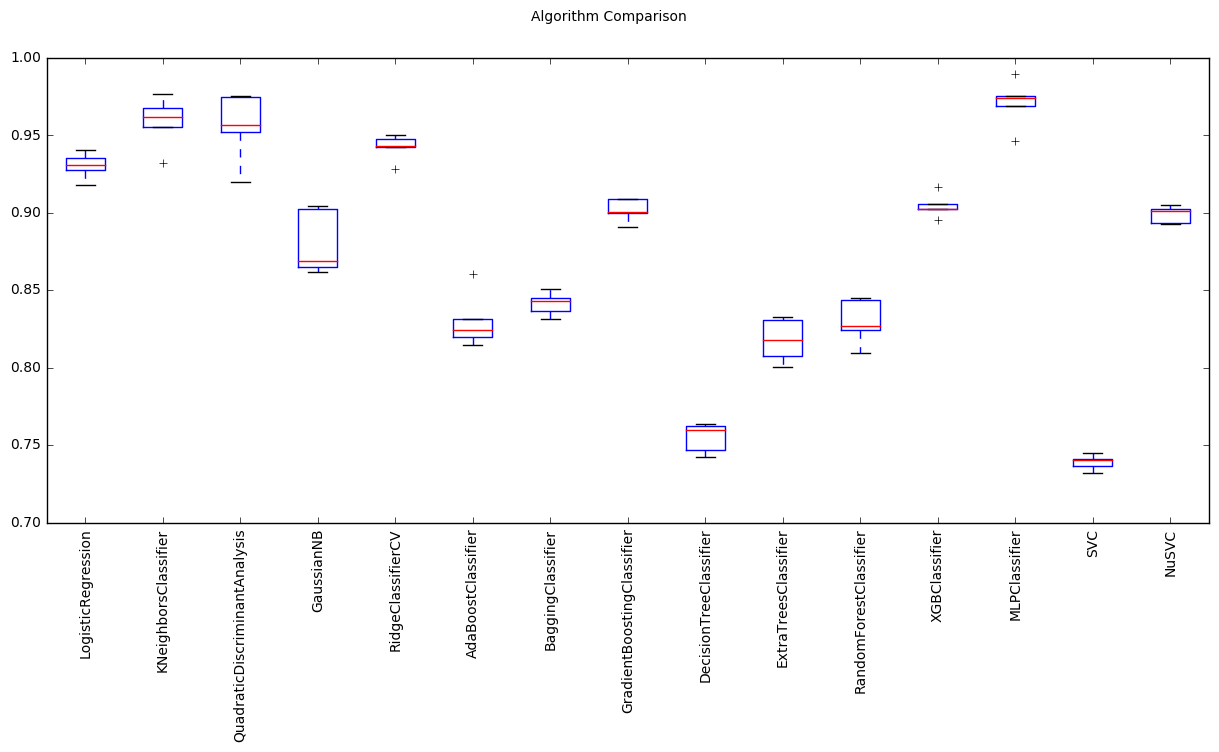

[array([ 0.94038748,  0.93059701,  0.92761194,  0.91791045,  0.93507463]),
 array([ 0.95529061,  0.97686567,  0.96791045,  0.93208955,  0.9619403 ]),
 array([ 0.95678092,  0.97462687,  0.97537313,  0.92014925,  0.95223881]),
 array([ 0.90461997,  0.8619403 ,  0.86492537,  0.86865672,  0.90223881]),
 array([ 0.95007452,  0.94776119,  0.94328358,  0.92835821,  0.94253731]),
 array([ 0.82414307,  0.83134328,  0.82014925,  0.81492537,  0.86044776]),
 array([ 0.83159463,  0.84477612,  0.83656716,  0.84328358,  0.85074627]),
 array([ 0.90014903,  0.89104478,  0.90074627,  0.90895522,  0.90895522]),
 array([ 0.74217586,  0.75970149,  0.76268657,  0.74701493,  0.76343284]),
 array([ 0.83308495,  0.80074627,  0.81791045,  0.80746269,  0.83059701]),
 array([ 0.84351714,  0.82686567,  0.82462687,  0.80970149,  0.84477612]),
 array([ 0.9023845 ,  0.89552239,  0.90223881,  0.90597015,  0.91641791]),
 array([ 0.96870343,  0.98955224,  0.9738806 ,  0.94626866,  0.97537313]),
 array([ 0.7414307 ,  0.7

In [27]:
evaluation_model(X_train_to_train[predictors].values, 
                 X_train_to_train[target].values, 
                 models = list(zip(names, classifiers)), 
                 num_folds = 5, 
                 seed = random_state)

Nous avons particulièrement observé ces modèles cependant nous présentons ici ceux que nous avons utilisés pour produire notre resultat final en fonction des performances que nous obtenions au fil des tests. Nous retenons:

  - LogisticRegression
  - KNeighborsClassifier
  - MLPClassifier
  - NuSVC
  - QDA
  - XGBClassifier


### **Etape 4:** Exploration des modèles retenus en se basant des résultats de la phase 3

Afin de mieux visualiser les modèles que nous explorons avbec nos grilles, nous avons écrit une fonction **report** qui permet d'afficher le classement des meilleurs modèles obtenus avec un e grille

In [28]:
def report(results, n_top=5):
    """ cette fonction permet d'afficher un classement des n meilleurs modèles obtenus avec une grille
    - results: objet GridSearchCV.grid_scores_
    - n_top: nombre de modèle à afficher
    """
    means = [result.cv_validation_scores.mean() for result in results]
    for i in range(n_top):
        candidate = results[np.array(means).argsort()[::-1][i]]
        print("Model with rank: {0}".format(i))
        print("Mean validation score: {0:.8f} (std: {1:.8f})".format(
                  candidate.cv_validation_scores.mean(),
                  candidate.cv_validation_scores.std()))
        print("Parameters: {0}".format(candidate.parameters))
        print("")

Avant de soumettre notre travail au tableau pour un modèle donnée, il serait intéresant de definir une fonction qui calcule les bons seuils de probablité. Ces seuils permettront en fait de dire si nous devons predire 1, -1 ou 0 en fonction de l'intervalle dans le quel la probabilité se retrouve.

In [29]:
# performance Criterion
def compute_pred_score(y_true, y_pred):
    y_comp = y_true * y_pred
    score = float(10*np.sum(y_comp == -1) + np.sum(y_comp == 0))
    score /= y_comp.shape[0]
    return score

def compute_class(probability, threshold_pos, threshold_neg):
    """ cette fonction permet d'afficher un classement des n meilleurs modèles obtenus avec une grille
    - probability: vecteur de probabilités
    - threshold_pos: seuil des probabilités > 0.5. predire 1 si probability > 0.5 + threshold_pos
    - threshold_neg: seuil des probabilités < 0.5. predire -1 si probability < 0.5 - threshold_pos7
                                                   predire 0 dans le cas contarire des deux cas precedents
    """
    y_pred = np.zeros(len(probability))
    y_pred[np.where( probability >= (0.5 + threshold_pos) )] = 1
    y_pred[np.where( probability <= (0.5 - threshold_neg) )] = -1
    return y_pred

def compute_threshold(probability, critical_bound_array, y_train):
    """ cette fonction permet de caculé le seuil qui minimise le score
    - probability: vecteur de probabilités
    - critical_bound: vecteur de seuil a utiliser pour determiner les classes 
    - y_train: vrai label des données
    """
    score_min = 1
    best_threshold_pos = 0
    best_threshold_neg = 0
    
    for threshold_pos in critical_bound_array:
        y_pred_train = compute_class(probability, threshold_pos, best_threshold_neg)
        score = compute_pred_score(y_train, y_pred_train)
        if score < score_min:
            best_threshold_pos = threshold_pos
            score_min = score
    
    for threshold_neg in critical_bound_array:
        y_pred_train = compute_class(probability, best_threshold_pos, threshold_neg)
        score = compute_pred_score(y_train, y_pred_train)
        if score < score_min:
            best_threshold_neg = threshold_neg
            score_min = score
            
    return best_threshold_pos,best_threshold_neg,score_min

Divisons nos données de train en deux ensembles: un ensemble pour entraine r le modèle et un autre pour valider les seuils

In [30]:
train, validation = train_test_split(X_train_to_train, test_size=0.05, random_state=random_state)
train.shape, validation.shape

((6366, 129), (336, 129))

**Modèle 1: LogisticRegression**

Recherche des paramètres

In [31]:
param_grid = [{ 'penalty':['l2','l1'],
               'tol':[0.00001, 0.0001,  0.001], 
               'C':[34, 33, 32, 31, 29, 28, 27, 26, 25, 30],
               'max_iter'    : [500, 1000]
             }]

lr =  LogisticRegression(penalty='l2', 
                         tol=0.0001, 
                         C=1.0, 
                         max_iter=100,
                         random_state=random_state, 
                         n_jobs=1)

#accuracy, roc_auc, f1, my_custom_loss_func
grid_lr = GridSearchCV(lr, param_grid, n_jobs=-1, cv=3, verbose=1, scoring="average_precision")
%time grid_lr = grid_lr.fit(X_train_to_train[predictors], X_train_to_train[target])
print("Best estimator found by grid search:")
print(grid_lr.best_params_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   22.4s finished


CPU times: user 6.6 s, sys: 272 ms, total: 6.87 s
Wall time: 22.9 s
Best estimator found by grid search:
{'tol': 0.001, 'penalty': 'l1', 'C': 34, 'max_iter': 500}


In [32]:
report(grid_lr.grid_scores_,10)

Model with rank: 0
Mean validation score: 0.99080705 (std: 0.00047443)
Parameters: {'tol': 0.001, 'penalty': 'l1', 'C': 34, 'max_iter': 500}

Model with rank: 1
Mean validation score: 0.99080705 (std: 0.00047443)
Parameters: {'tol': 0.001, 'penalty': 'l1', 'C': 34, 'max_iter': 1000}

Model with rank: 2
Mean validation score: 0.99080691 (std: 0.00047508)
Parameters: {'tol': 0.0001, 'penalty': 'l1', 'C': 33, 'max_iter': 500}

Model with rank: 3
Mean validation score: 0.99080691 (std: 0.00047508)
Parameters: {'tol': 0.0001, 'penalty': 'l1', 'C': 33, 'max_iter': 1000}

Model with rank: 4
Mean validation score: 0.99080660 (std: 0.00047629)
Parameters: {'tol': 0.001, 'penalty': 'l1', 'C': 33, 'max_iter': 500}

Model with rank: 5
Mean validation score: 0.99080660 (std: 0.00047629)
Parameters: {'tol': 0.001, 'penalty': 'l1', 'C': 33, 'max_iter': 1000}

Model with rank: 6
Mean validation score: 0.99080649 (std: 0.00047811)
Parameters: {'tol': 0.001, 'penalty': 'l1', 'C': 32, 'max_iter': 500}

M

Test du modèle au Tableau avec les meilleur paramètres retenu: 

{'tol': 1e-05, 'penalty': 'l2', 'max_iter': 500, 'C': 30}

In [33]:
lr =  LogisticRegression(penalty='l2', 
                         tol= 1e-05, 
                         C=30, 
                         max_iter=500,
                         random_state=random_state, 
                         n_jobs=-1)
lr.fit(X_train_to_train[predictors], X_train_to_train[target])

LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=42, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False)

In [34]:
probs = lr.predict_proba(X_test[predictors])[:,1]
y_pred_test = compute_class(probs, 0, 0)
np.savetxt("lr_final.txt", y_pred_test, fmt='%d')

Nous obtenons un score de **0.399717514124** au tableau

**Modèle 2: KNeighborsClassifier**

Recherche des paramètres

In [35]:
param_grid = [{'n_neighbors':[37, 38],#, 20, 22, 2              
               'weights':['distance'],#0.0001, 0.005, 0.001
                  'metric':['minkowski'],
               'p':[2]
              }]

knn = KNeighborsClassifier(n_jobs=-1, weights = 'distance', p = 2, n_neighbors = 37, metric = 'minkowski')


grid_knn = GridSearchCV(knn, param_grid, n_jobs=-1, cv=3, verbose=1, scoring="average_precision")
%time grid_knn = grid_knn.fit(X_train_to_train[predictors], X_train_to_train[target])
print("Best estimator found by grid search:")
print(grid_knn.best_score_,grid_knn.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
CPU times: user 720 ms, sys: 118 ms, total: 838 ms
Wall time: 11.9 s
Best estimator found by grid search:
0.995919758591 {'p': 2, 'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 37}


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   11.7s finished


In [36]:
report(grid_knn.grid_scores_,2)

Model with rank: 0
Mean validation score: 0.99591971 (std: 0.00077517)
Parameters: {'p': 2, 'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 37}

Model with rank: 1
Mean validation score: 0.99584898 (std: 0.00078623)
Parameters: {'p': 2, 'weights': 'distance', 'metric': 'minkowski', 'n_neighbors': 38}



Test du modèle au Tableau avec les meilleur paramètres retenu: 

weights = 'distance', p = 2, n_neighbors = 37, metric = 'minkowski'

In [40]:
knn = KNeighborsClassifier(n_jobs=-1, weights = 'distance', p = 2, n_neighbors = 37, metric = 'minkowski')

knn.fit(X_train_to_train[predictors], X_train_to_train[target])

probs = knn.predict_proba(X_test[predictors])[:,1]
y_pred_test = compute_class(probs, 0, 0)
np.savetxt("knn_final.txt", y_pred_test, fmt='%d')

Nous obtenons un score de  **0.2565913371** au tableau

**Modèle 3: MLPClassifier**

Recherche des paramètres

In [41]:
param_grid = [{ 'hidden_layer_sizes':[(2047,)], 
               'activation':['relu'], 
               'solver':['adam'],
               'alpha':[1e-6],
               'max_iter': [200],
               'tol': [1e-5],#0.0001, 0.00001
               'beta_1': [0.9],
               'beta_2': [0.999],
               'epsilon': [1e-08],
             },
             ]

mlp =  MLPClassifier(hidden_layer_sizes=(2047,), 
                     activation='relu', 
                     solver='adam', 
                     alpha=1e-6,
                     max_iter=200, 
                     shuffle=False, 
                     random_state=random_state, 
                     tol=1e-5,  
                     beta_1=0.9, 
                     beta_2=0.999, 
                     epsilon=1e-08)

#accuracy, roc_auc, f1, my_custom_loss_func
grid_mlp = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=2, verbose=1, scoring="average_precision")
%time grid_mlp = grid_mlp.fit(X_train_to_train[predictors], X_train_to_train[target])
print("Best estimator found by grid search:")
print(grid_mlp.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   29.1s finished


CPU times: user 2min 22s, sys: 2.91 s, total: 2min 25s
Wall time: 1min 5s
Best estimator found by grid search:
{'solver': 'adam', 'beta_2': 0.999, 'epsilon': 1e-08, 'max_iter': 200, 'alpha': 1e-06, 'activation': 'relu', 'beta_1': 0.9, 'hidden_layer_sizes': (2047,), 'tol': 1e-05}


Test du modèle au Tableau avec les meilleur paramètres retenu: 

hidden_layer_sizes=(2047,),  activation='relu',  solver='adam',  alpha=1e-6, max_iter=200,  shuffle=False,  random_state=random_state,  tol=1e-5,   beta_1=0.9,  beta_2=0.999,  epsilon=1e-08

In [42]:
mlp =  MLPClassifier(hidden_layer_sizes=(2047,), 
                     activation='relu', 
                     solver='adam', 
                     alpha=1e-6,
                     max_iter=200, 
                     shuffle=False, 
                     random_state=random_state, 
                     tol=1e-5,  
                     beta_1=0.9, 
                     beta_2=0.999, 
                     epsilon=1e-08)

mlp.fit(X_train_to_train[predictors], X_train_to_train[target])

probs = mlp.predict_proba(X_test[predictors])[:,1]
y_pred_test = compute_class(probs, 0, 0)
np.savetxt("mlp_final.txt", y_pred_test, fmt='%d')

Nous obtenons un score de  ** 0.221280602637** au tableau

**Modèle 4: NuSVC**

Recherche des paramètres

In [43]:
from sklearn.svm import NuSVC

param_grid = [{ 'nu': [0.114,0.115 ,0.116,0.117 ,0.118 ,0.119, 0.12, 0.121, 0.122, 0.123, 0.124, 0.125],
               'kernel':['rbf'],
               'gamma':[1, 1.75, 'auto'], 
               'tol'    : [0.001]
             },

#             { 'nu': [0.1, 0.2, 0.3, 0.4, 0.5],
#               'kernel':['sigmoid'],
#               'gamma':[1, 1.75, 'auto'], 
#               'tol'    : [0.001]
#             }
#    ,
#    { 'nu': [0.1, 0.2, 0.3, 0.4, 0.5],
#               'kernel':['poly'],
#               'degree':[3, 6, 10],
#               'gamma':[1, 1.75, 'auto'], 
#               'tol'    : [0.001]
#             }
            
             ]

nusvc =  NuSVC(nu=0.12, 
             kernel='rbf', 
             degree=3, 
             gamma=1.75, 
             coef0=0.0, 
             shrinking=True, 
             probability=False, 
             tol=0.001, 
             cache_size=200, 
             class_weight=None, 
             verbose=False, 
             max_iter=-1, 
             decision_function_shape=None, 
             random_state=None)


#accuracy, roc_auc, f1, my_custom_loss_func
grid_nusvc = GridSearchCV(nusvc, param_grid, n_jobs=-1, cv=3, verbose=1, scoring="average_precision")
%time grid_nusvc = grid_nusvc.fit(X_train_to_train[predictors], X_train_to_train[target])
print("Best estimator found by grid search:")
print(grid_nusvc.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.5min finished


CPU times: user 6.63 s, sys: 263 ms, total: 6.89 s
Wall time: 1min 31s
Best estimator found by grid search:
{'gamma': 1.75, 'nu': 0.122, 'tol': 0.001, 'kernel': 'rbf'}


Test du modèle au Tableau avec les meilleur paramètres retenu: 

nu=0.12, kernel='rbf', degree=3, gamma=1.75, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None,  verbose=False, max_iter=-1, decision_function_shape=None, random_state=None

In [44]:
nusvc =  NuSVC(nu=0.12, 
             kernel='rbf', 
             degree=3, 
             gamma=1.75, 
             coef0=0.0, 
             shrinking=True, 
             probability=True, 
             tol=0.001, 
             cache_size=200, 
             class_weight=None, 
             verbose=False, 
             max_iter=-1, 
             decision_function_shape=None, 
             random_state=None)

nusvc.fit(X_train_to_train[predictors], X_train_to_train[target])

probs = nusvc.predict_proba(X_test[predictors])[:,1]
y_pred_test = compute_class(probs, 0, 0)
np.savetxt("nusvc_final.txt", y_pred_test, fmt='%d')

Nous obtenons un score de  **0.190677966102** au tableau

**Modèle 5: XGBClassifier**

Recherche des paramètres. Commencons par definir des fonctions utiles pour ce classifieur

In [45]:
def XGBoostCV(xgb_model, dtrain, predictors, target, cv_folds, early_stopping_rounds):
    xgb_param = xgb_model.get_xgb_params()
    xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
    #xgtest = xgb.DMatrix(dtest[predictors].values)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        
    n_estimators = cvresult.shape[0]
    last_iteration = cvresult.iloc[n_estimators-1]
    print ("[%d] CV Score : test auc mean: %.6f | test auc std: %.6f | train auc mean: %.6f | train auc std: %.6f"  
               % (n_estimators,
                  last_iteration['test-auc-mean'],
                  last_iteration['test-auc-std'],
                  last_iteration['train-auc-mean'],
                  last_iteration['train-auc-std'],))
    
    return cvresult, n_estimators
    
    
def modelfit(alg, dtrain, dtest, predictors, target, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        _, n_estimators = XGBoostCV(alg, dtrain, predictors, target, cv_folds, early_stopping_rounds)
        alg.set_params(n_estimators=n_estimators)
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report Train")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print ("AUC Score : %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
    
    #Predict test set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report test set:
    print ("\nModel Report Test")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtest[target].values, dtest_predictions))
    print ("AUC Score : %f" % metrics.roc_auc_score(dtest[target], dtest_predprob))
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

#test_results = pd.read_csv('test_results.csv')
def modelfit_base(alg, dtrain, dtest, predictors, target, useTrainCV=True, cv_folds=3, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        #xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
        
        niter = cvresult.shape[0]
        last_iteration = cvresult.iloc[niter-1]
        print ("[%d] CV Score : test auc mean: %.6f | test auc std: %.6f | train auc mean: %.6f | train auc std: %.6f"  
               % (niter,
                  last_iteration['test-auc-mean'],
                  last_iteration['test-auc-std'],
                  last_iteration['train-auc-mean'],
                  last_iteration['train-auc-std'],))


Recherche

In [46]:
param_grid = { 
 'n_estimators':[5000],
 'learning_rate':[0.01],
 'max_depth': [4],
 'gamma':[1e-05],# i/10.0 for i in range(0,3)
 'min_child_weight': [3],
 'subsample':[0.8], # 0.7 i/10.0 for i in range(7,10)
 'colsample_bytree':[0.8], #
 'reg_alpha':[1e-6],#0.1 #1e-5, 1e-2, 0.1, 1
 'reg_lambda':[1],#0.1 #1e-5, 1e-2, 0.1, 1
 'base_score':[0.4],#0.1 #1e-5, 1e-2, 0.1, 1
}

xgb_mod = XGBClassifier(
           max_depth=4, 
           learning_rate=0.01, 
           n_estimators=5000, 
           silent=True, 
           objective='binary:logistic', 
           nthread=-1, 
           gamma=1e-05, 
           min_child_weight=3, 
           subsample=0.8, 
           colsample_bytree=0.8, 
           reg_alpha=1e-6, 
           reg_lambda=1,  
           base_score=0.4, 
           seed=random_state)

grid_xgb = GridSearchCV(xgb_mod, param_grid, n_jobs=-1, cv=5, verbose=1, scoring='average_precision')
%time grid_xgb = grid_xgb.fit(X_train_to_train[predictors], X_train_to_train[target])
print("Best estimator found by grid search:")
print(grid_xgb.best_score_,grid_xgb.best_params_)
#%time xgb = xgb.fit(X_train_filtered[predictors], X_train_filtered_train[target])

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.2min remaining:  6.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


CPU times: user 3min 15s, sys: 216 ms, total: 3min 15s
Wall time: 7min 30s
Best estimator found by grid search:
0.994650862117 {'gamma': 1e-05, 'n_estimators': 5000, 'colsample_bytree': 0.8, 'reg_alpha': 1e-06, 'base_score': 0.4, 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 0.8, 'reg_lambda': 1, 'min_child_weight': 3}


Test du modèle au Tableau avec les meilleur paramètres retenu: 

max_depth=4, learning_rate=0.01, n_estimators=5000, silent=True, objective='binary:logistic', nthread=-1, gamma=1e-05, min_child_weight=3, subsample=0.8, colsample_bytree=0.8, reg_alpha=1e-6, reg_lambda=1,  base_score=0.4, seed=random_state

In [47]:
xgb_mod = XGBClassifier(
           max_depth=4, 
           learning_rate=0.01, 
           n_estimators=5000, 
           silent=True, 
           objective='binary:logistic', 
           nthread=-1, 
           gamma=1e-05, 
           min_child_weight=3, 
           subsample=0.8, 
           colsample_bytree=0.8, 
           reg_alpha=1e-6, 
           reg_lambda=1,  
           base_score=0.4, 
           seed=random_state)

xgb_mod.fit(X_train_to_train[predictors], X_train_to_train[target])

probs = xgb_mod.predict_proba(X_test[predictors])[:,1]
y_pred_test = compute_class(probs, 0, 0)
np.savetxt("xgb_mod_final.txt", y_pred_test, fmt='%d')

Nous obtenons un score de  **0.430790960452** au tableau

**Modèle 6: ExtraTreesClassifier**

Recherche des paramètres

In [48]:
param_grid = [{ 'n_estimators' : [50],
                'criterion' : ['entropy'], # 'entropy'
                 'max_depth':[15], # 25
                 'min_samples_split':[2], # 14
                 'min_samples_leaf':[2],  # 3
                 'max_features':['auto'], # 5
                 'min_impurity_split':[1e-012] # 0.001
                }
              ]

et = ExtraTreesClassifier(n_estimators=50, 
                           criterion= 'entropy', 
                           max_depth=27, 
                           min_samples_split=14, 
                           min_samples_leaf=3, 
                           max_features=13, 
                           min_impurity_split=1e-07,
                           bootstrap=False, 
                           oob_score=False, 
                           n_jobs=-1, 
                           random_state=random_state, 
                           verbose=0, 
                           warm_start=False, 
                           class_weight=None)

#accuracy, roc_auc, f1, my_custom_loss_func
grid_et = GridSearchCV(et, param_grid, n_jobs=-1, cv=5, verbose=1, scoring="average_precision")
%time grid_et = grid_et.fit(X_train_to_train[predictors], X_train_to_train[target])
print("Best estimator found by grid search:")
print(grid_et.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


CPU times: user 759 ms, sys: 76.5 ms, total: 835 ms
Wall time: 1.04 s
Best estimator found by grid search:
{'n_estimators': 50, 'min_samples_split': 2, 'min_impurity_split': 1e-12, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 2}


Test du modèle au Tableau avec les meilleur paramètres retenu: 

n_estimators=50, criterion= 'entropy', max_depth=27,  min_samples_split=14,  min_samples_leaf=3,  max_features=13, min_impurity_split=1e-07, bootstrap=False, oob_score=False, n_jobs=-1, random_state=random_state, verbose=0, warm_start=False, class_weight=None

In [49]:
et = ExtraTreesClassifier(n_estimators=50, 
                           criterion= 'entropy', 
                           max_depth=27, 
                           min_samples_split=14, 
                           min_samples_leaf=3, 
                           max_features=13, 
                           min_impurity_split=1e-07,
                           bootstrap=False, 
                           oob_score=False, 
                           n_jobs=-1, 
                           random_state=random_state, 
                           verbose=0, 
                           warm_start=False, 
                           class_weight=None)

et.fit(X_train_to_train[predictors], X_train_to_train[target])

probs = et.predict_proba(X_test[predictors])[:,1]
y_pred_test = compute_class(probs, 0, 0)
np.savetxt("et_final.txt", y_pred_test, fmt='%d')

Nous obtenons un score de  **1.50423728814** au tableau 

Test du modèle au Tableau avec les meilleur paramètres retenu: 

{'normalize': False}, alphas=(0.1, 1.0, 10.0, 100, 1000, 10000)

**Modèle 8: QuadraticDiscriminantAnalysis**

Recherche des paramètres

In [50]:
param_grid = [{ 'reg_param' : [0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.07,0.08,0.09],
                'store_covariances' : [True, False], 
                 'tol':[1e-11,1e-10,1e-9,1e-8], 
                }
              ]

qda = QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0, store_covariances=False, tol=0.0001)

#accuracy, roc_auc, f1, my_custom_loss_func
grid_qda = GridSearchCV(qda, param_grid, n_jobs=-1, cv=5, verbose=1, scoring="average_precision")
%time grid_qda = grid_qda.fit(X_train_to_train[predictors], X_train_to_train[target])
print("Best estimator found by grid search:")
print(grid_qda.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.4s


CPU times: user 5.88 s, sys: 266 ms, total: 6.15 s
Wall time: 16.2 s
Best estimator found by grid search:
{'store_covariances': True, 'tol': 1e-11, 'reg_param': 0.05}


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   16.0s finished


In [51]:
report(grid_qda.grid_scores_,5)

Model with rank: 0
Mean validation score: 0.99624492 (std: 0.00369464)
Parameters: {'store_covariances': True, 'tol': 1e-08, 'reg_param': 0.05}

Model with rank: 1
Mean validation score: 0.99624492 (std: 0.00369464)
Parameters: {'store_covariances': True, 'tol': 1e-11, 'reg_param': 0.05}

Model with rank: 2
Mean validation score: 0.99624492 (std: 0.00369464)
Parameters: {'store_covariances': True, 'tol': 1e-10, 'reg_param': 0.05}

Model with rank: 3
Mean validation score: 0.99624492 (std: 0.00369464)
Parameters: {'store_covariances': True, 'tol': 1e-09, 'reg_param': 0.05}

Model with rank: 4
Mean validation score: 0.99624492 (std: 0.00369464)
Parameters: {'store_covariances': False, 'tol': 1e-11, 'reg_param': 0.05}



Test du modèle au Tableau avec les meilleur paramètres retenu: 

{'store_covariances': True, 'tol': 1e-11, 'reg_param': 0.06}

In [52]:
qda = QuadraticDiscriminantAnalysis(priors=None, reg_param=0.06, store_covariances=True, tol=1e-11)

qda.fit(X_train_to_train[predictors], X_train_to_train[target])

probs = qda.predict_proba(X_test[predictors])[:,1]
y_pred_test = compute_class(probs, 0, 0)
np.savetxt("qda_final.txt", y_pred_test, fmt='%d')

Nous obtenons un score de  **0.69209039548** au tableau   

## Récapitulatif des scores

**nu_svc:** 0.190677966102

**mlp:**  0.221280602637

**knn:** 0.2565913371

**lr:** 0.399717514124 

**xgb:** 0.430790960452

**qda:** 0.69209039548

**et:** 1.50423728814

### **Etape 5:** Combinaison des modèles

#### 5.1 vote sur les meilleurs modèles
    
Nous choississons de combiner les 3 meilleurs modèles en definsissant des poids au et à mesure sur chaque modèle; ainsi on pourra modifier les poids en fonction du score que nous allons obtenir au tableau

In [53]:
lr =  LogisticRegression(penalty='l2', 
                         tol= 1e-05, 
                         C=30, 
                         max_iter=5000,
                         random_state=random_state, 
                         n_jobs=-1)
%time lr.fit(X_train_to_train[predictors], X_train_to_train[target])


nusvc =  NuSVC(nu=0.12, 
             kernel='rbf', 
             degree=3, 
             gamma=1.75, 
             coef0=0.0, 
             shrinking=True, 
             probability=True, 
             tol=0.001, 
             cache_size=200, 
             class_weight=None, 
             verbose=False, 
             max_iter=-1, 
             decision_function_shape=None, 
             random_state=None)
%time nusvc = nusvc.fit(X_train_to_train[predictors], X_train_to_train[target])


mlp =  MLPClassifier(hidden_layer_sizes=(2047,), 
                     activation='relu', 
                     solver='adam', 
                     alpha=1e-6,
                     max_iter=200, 
                     shuffle=False, 
                     random_state=random_state, 
                     tol=1e-5,  
                     beta_1=0.9, 
                     beta_2=0.999, 
                     epsilon=1e-08)
%time mlp = mlp.fit(X_train_to_train[predictors], X_train_to_train[target])



knn = KNeighborsClassifier(n_jobs=-1, weights = 'distance', p = 2, n_neighbors = 37, metric = 'minkowski')
%time knn = knn.fit(X_train_to_train[predictors], X_train_to_train[target])

xgb_mod = XGBClassifier(
           max_depth=4, 
           learning_rate=0.01, 
           n_estimators=5000, 
           silent=True, 
           objective='binary:logistic', 
           nthread=-1, 
           gamma=1e-05, 
           min_child_weight=3, 
           subsample=0.8, 
           colsample_bytree=0.8, 
           reg_alpha=1e-6, 
           reg_lambda=1,  
           base_score=0.4, 
           seed=random_state)
%time xgb_mod = xgb_mod.fit(X_train_to_train[predictors], X_train_to_train[target])

CPU times: user 790 ms, sys: 8.94 ms, total: 799 ms
Wall time: 257 ms
CPU times: user 23.9 s, sys: 111 ms, total: 24 s
Wall time: 24 s
CPU times: user 2min 28s, sys: 6.14 s, total: 2min 34s
Wall time: 38.8 s
CPU times: user 115 ms, sys: 3.98 ms, total: 119 ms
Wall time: 29.7 ms
CPU times: user 3min 17s, sys: 105 ms, total: 3min 17s
Wall time: 3min 16s


In [54]:
from sklearn.ensemble import VotingClassifier

estim = [("nusvc",nusvc),
         ("knn",knn),
        ("mlp",mlp),
        #("xgb_mod",xgb_mod)
        ]

# create the ensemble model
ensemble = VotingClassifier(estimators = estim, n_jobs=-1, voting='soft', weights=[2,1.5,1.5])
#indice = np.random.randint(0,X_train.shape[0],1000)
%time ensemble.fit(X_train_to_train[predictors], X_train_to_train[target])

CPU times: user 128 ms, sys: 87.9 ms, total: 216 ms
Wall time: 35.6 s


VotingClassifier(estimators=[('nusvc', NuSVC(cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma=1.75, kernel='rbf',
   max_iter=-1, nu=0.12, probability=True, random_state=None,
   shrinking=True, tol=0.001, verbose=False)), ('knn', KNeighborsClassifier(algorithm='auto', l...=False, solver='adam', tol=1e-05, validation_fraction=0.1,
       verbose=False, warm_start=False))],
         n_jobs=-1, voting='soft', weights=[2, 1.5, 1.5])

Test du modèle au tableau

In [55]:
probs = ensemble.predict_proba(X_test)[:,1]
y_pred_test = compute_class(probs,  0., 0.)
np.savetxt("ensemble_final.txt", y_pred_test, fmt='%d')

Nous obtenons Notre meilleur score au tableau **0.176553672316** . 

Nous avons ajusté les seuils au tableau pour voir finalement quel sont les meilleurs seuils, on obtient **0.293, 0.377** comme seuils. Appliquons les

In [56]:
y_pred_test = compute_class(probs,  0.293, 0.37775)
np.savetxt("ensemble_final.txt", y_pred_test, fmt='%d')